# Feature Extraction Verification

This notebook audits the core logic in `src/features/feature_extraction.py`.
Assuming the raw data is correct (verified in `notebooks/01`), we now check the transformation of raw signals into meaningful physiological features.

**Objectives:**
1.  **EDA**: Visualizing the decomposition into Phasic (SCR events) and Tonic (SCL baseline) components.
2.  **ECG**: Verifying R-peak detection on the downsampled (35Hz) signal.
3.  **Physiological Features**: Checking if extracted metrics (HRV, Temp Slope, SCR Frequency) show statistical separation between baseline and stress states.

In [1]:
# 1. Import Libraries & Load Configuration
%load_ext autoreload
%autoreload 2

import sys
import importlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import load_config
from src.data.make_dataset import WESADPreprocessor

# Force reload of feature_extraction module to pick up new logic
import src.features.feature_extraction
importlib.reload(src.features.feature_extraction)
from src.features.feature_extraction import FeatureExtractor

# Force reload of plots module to pick up new functions
import src.visualization.plots
importlib.reload(src.visualization.plots)
from src.visualization.plots import (
    set_plot_style, 
    plot_eda_decomposition, 
    plot_ecg_audit, 
    plot_feature_separability, 
    plot_feature_importance_cohens_d, 
    plot_feature_pairplot, 
    plot_correlation_matrix, 
    get_top_discriminative_features,
    plot_temp_audit,
    plot_resp_audit
)

set_plot_style()
config = load_config()
print("Configuration Loaded.")

Configuration Loaded.


In [2]:
# 2. Load Preprocessed Data (Subject S2)
preprocessor = WESADPreprocessor()
subject_id = 'S2'

print(f"Loading data for {subject_id}...")
windows = preprocessor.process_subject(subject_id)
print(f"Successfully loaded {len(windows)} windows.")

# Basic check
print("Sample Window Keys:", windows[0].keys())

Loading data for S2...
2026-01-17 00:14:15,012 - src.data.make_dataset - INFO - Loading C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\raw\WESAD\S2\S2.pkl
2026-01-17 00:14:23,129 - src.data.make_dataset - INFO - Subject S2: 71 windows created.
Successfully loaded 71 windows.
Sample Window Keys: dict_keys(['subject_id', 'label', 'start_idx', 'ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP'])


## 3. Audit EDA Processing
We verify the logic used in `FeatureExtractor._process_eda`. 
We replicate the logic here to visualize the Phasic vs Tonic split and SCR peaks.

Auditing Window Index: 0


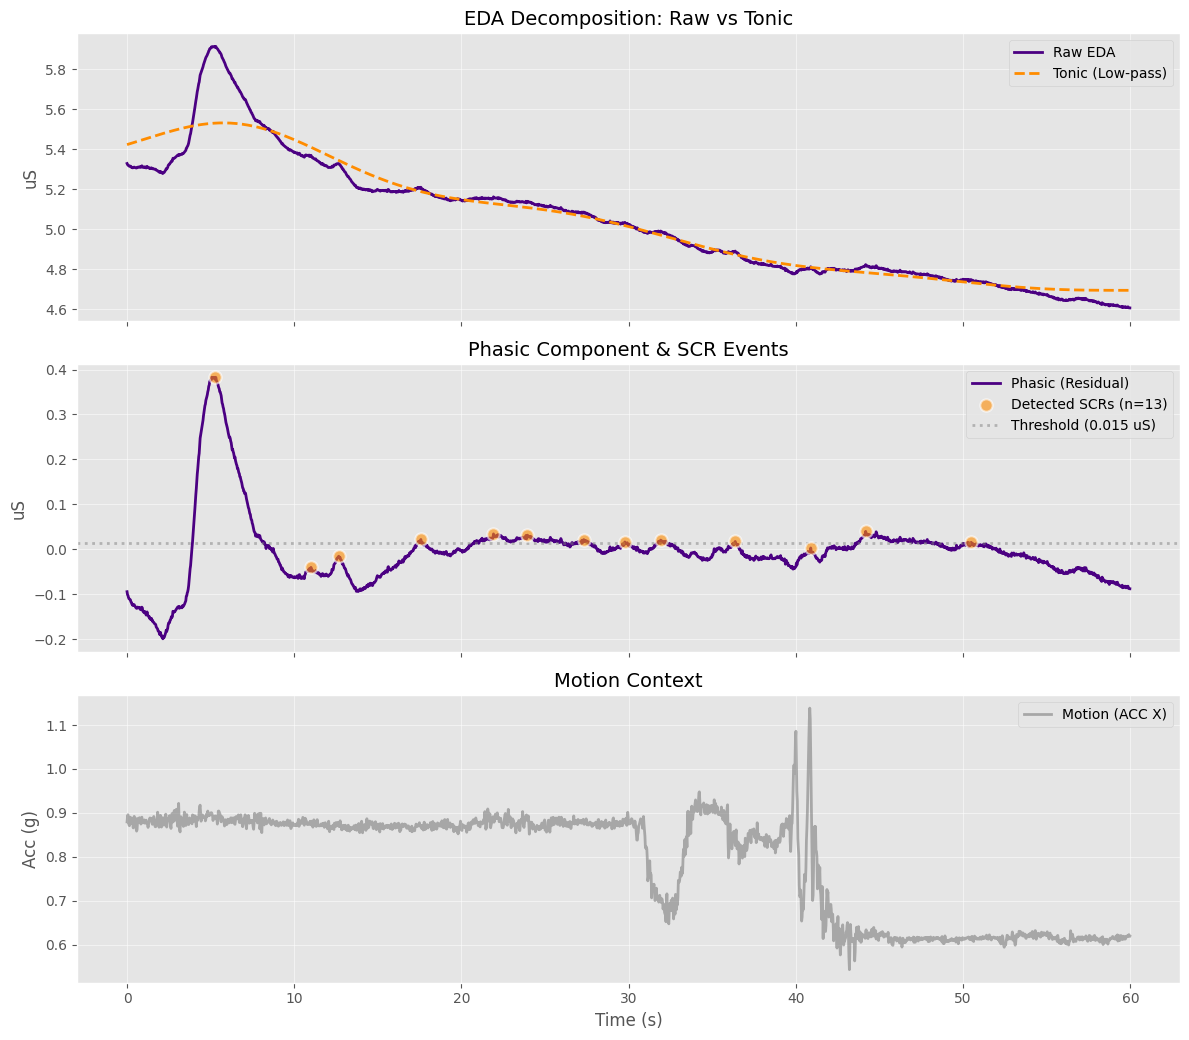

In [3]:
# Find a window with significant EDA activity (high range)
eda_ranges = [np.max(w['EDA']) - np.min(w['EDA']) for w in windows]
audit_idx = np.argmax(eda_ranges)
window = windows[audit_idx]
print(f"Auditing Window Index: {audit_idx}")

eda_signal = np.array(window['EDA'])
fs = config['data']['target_sampling_rate']
eda_threshold = config['features']['eda']['scr_threshold']

# --- Use Actual FeatureExtractor Logic ---
extractor = FeatureExtractor(config)
tonic, phasic, peaks = extractor.get_eda_components(eda_signal)

# --- Visualization ---
loc = config['data'].get('sensor_location', 'chest').upper()
fig = plot_eda_decomposition(
    time_axis=np.arange(len(eda_signal)) / fs,
    raw=eda_signal,
    tonic=tonic,
    phasic=phasic,
    peaks=peaks,
    threshold=eda_threshold,
    motion_signal=np.array(window['ACC_x']),
    save_folder=loc
)
plt.show()

## 4. Audit ECG Processing
Verify if the simple bandpass + peak detection works reasonably well on the 35Hz downsampled ECG.

Detected 81 peaks
Threshold used: 0.1869


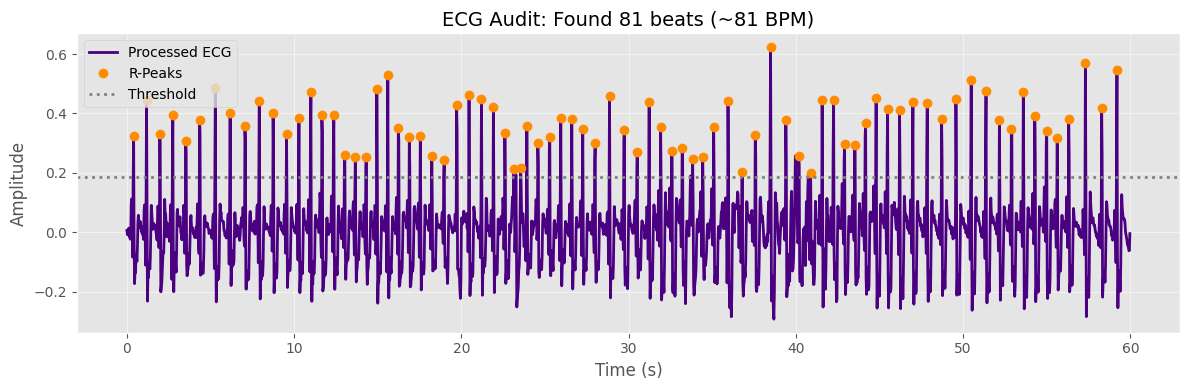

In [4]:
ecg_signal = np.array(window['ECG'])
fs = config['data']['target_sampling_rate']

# --- Use Actual FeatureExtractor Logic ---
extractor = FeatureExtractor(config)
clean_ecg, peaks, threshold_used = extractor.get_ecg_peaks(ecg_signal)

print(f"Detected {len(peaks)} peaks")
print(f"Threshold used: {threshold_used:.4f}")

# --- Visualization ---
loc = config['data'].get('sensor_location', 'chest').upper()
fig = plot_ecg_audit(
    time_axis=np.arange(len(ecg_signal)) / fs,
    clean_ecg=clean_ecg, 
    peaks=peaks,
    threshold=threshold_used,
    save_folder=loc
)
plt.show()

## 5. Audit Temperature & Respiration
We verify:
1.  **Temperature Slope**: Correlates with stress (skin temperature often drops initially during acute stress).
2.  **Respiration Rate**: Derived from the chest strap's respiration sensor.

Auditing Temperature Trend...


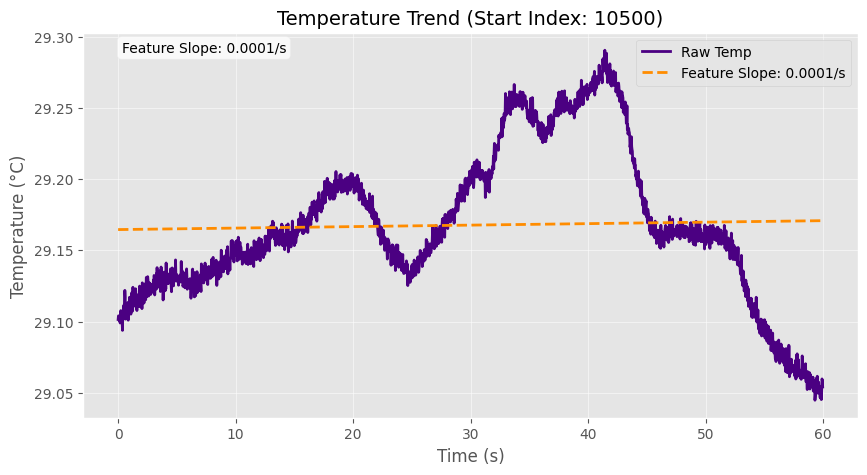

Auditing Respiration Rate...


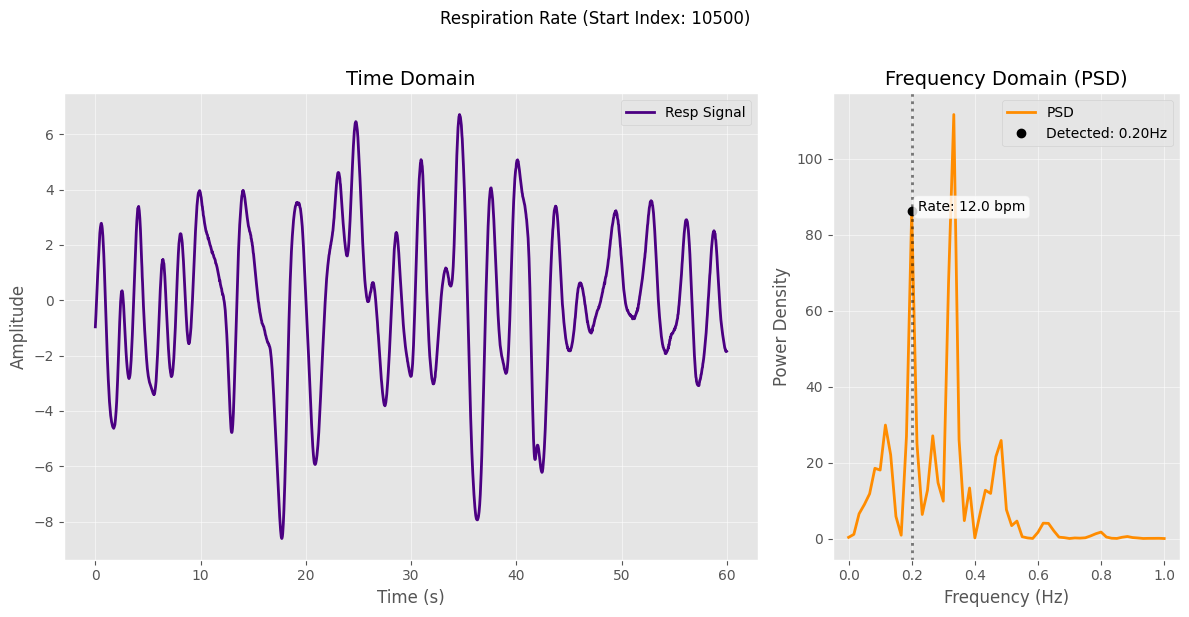

In [9]:
# --- Temperature Audit ---
temp_signal = np.array(window['TEMP'])

print("Auditing Temperature Trend...")
loc = config['data'].get('sensor_location', 'chest').upper()

# Calculate feature first
feats = extractor._process_temp(temp_signal)
slope_val = feats['temp_slope']

fig_temp = plot_temp_audit(
    time_axis=np.arange(len(temp_signal)) / fs,
    temp_signal=temp_signal,
    slope=slope_val,
    title=f"Temperature Trend (Start Index: {window['start_idx']})",
    save_folder=loc
)
plt.show()

# --- Respiration Audit ---
if 'RESP' in window:
    resp_signal = np.array(window['RESP'])
    print("Auditing Respiration Rate...")
    
    # Calculate rate using robust feature extractor logic
    feats = extractor._process_resp(resp_signal)
    detected_hz = feats['resp_rate_Hz']
    
    fig_resp = plot_resp_audit(
        time_axis=np.arange(len(resp_signal)) / fs,
        resp_signal=resp_signal,
        fs=fs,
        detected_rate=detected_hz, # Explicitly pass the detected rate for visualization
        title=f"Respiration Rate (Start Index: {window['start_idx']})",
        save_folder=loc
    )
    plt.show()
else:
    print("No RESP signal in this window.")

## 6. Generate Full Feature Vector
Run the `FeatureExtractor` on a single window to inspect the final output format (Pandas Series).
This confirms the integration of all modalities (EDA, ECG, TEMP, RESP, ACC).

In [6]:
extractor = FeatureExtractor(config)
features = extractor.extract_features(window)

print("--- Extracted Features ---")
feat_series = pd.Series(features)
print(feat_series)

# Check for nans
if feat_series.isnull().any():
    print("\nWARNING: NaNs detected!")
else:
    print("\nData Integrity Check: Pass (No NaNs)")

--- Extracted Features ---
eda_mean              5.037618
eda_std               0.302151
eda_tonic_mean        5.042005
eda_phasic_std        0.079035
eda_range             1.305083
eda_acc_scr_count    13.000000
temp_mean            29.167706
temp_std              0.053449
temp_min             29.044714
temp_max             29.290561
temp_slope            0.000104
acc_std               0.024116
acc_range             0.493602
acc_energy            0.000582
ecg_hr_bpm           81.632653
ecg_rmssd             0.077216
ecg_sdnn              0.114105
resp_mean            -0.041047
resp_std              2.872213
resp_range           15.325497
resp_rate_Hz          0.200000
resp_rate_bpm        12.000000
dtype: float64

Data Integrity Check: Pass (No NaNs)


## 7. Feature Separability Analysis
We extract features for a subset of windows (Subject S2) to visually verify discriminatory power.
**Violin Plots** are used to compare the distribution of each feature across 'Baseline' (1) and 'Stress' (2).
**Classification Expectation**: We expect significant shifts in features like `EDA_scr_peaks_mean` or `ECG_hr_mean`.

Plotting 22 features: ['acc_energy', 'acc_range', 'acc_std', 'ecg_hr_bpm', 'ecg_rmssd', 'ecg_sdnn', 'eda_acc_scr_count', 'eda_mean', 'eda_phasic_std', 'eda_range', 'eda_std', 'eda_tonic_mean', 'resp_mean', 'resp_range', 'resp_rate_Hz', 'resp_rate_bpm', 'resp_std', 'temp_max', 'temp_mean', 'temp_min', 'temp_slope', 'temp_std']


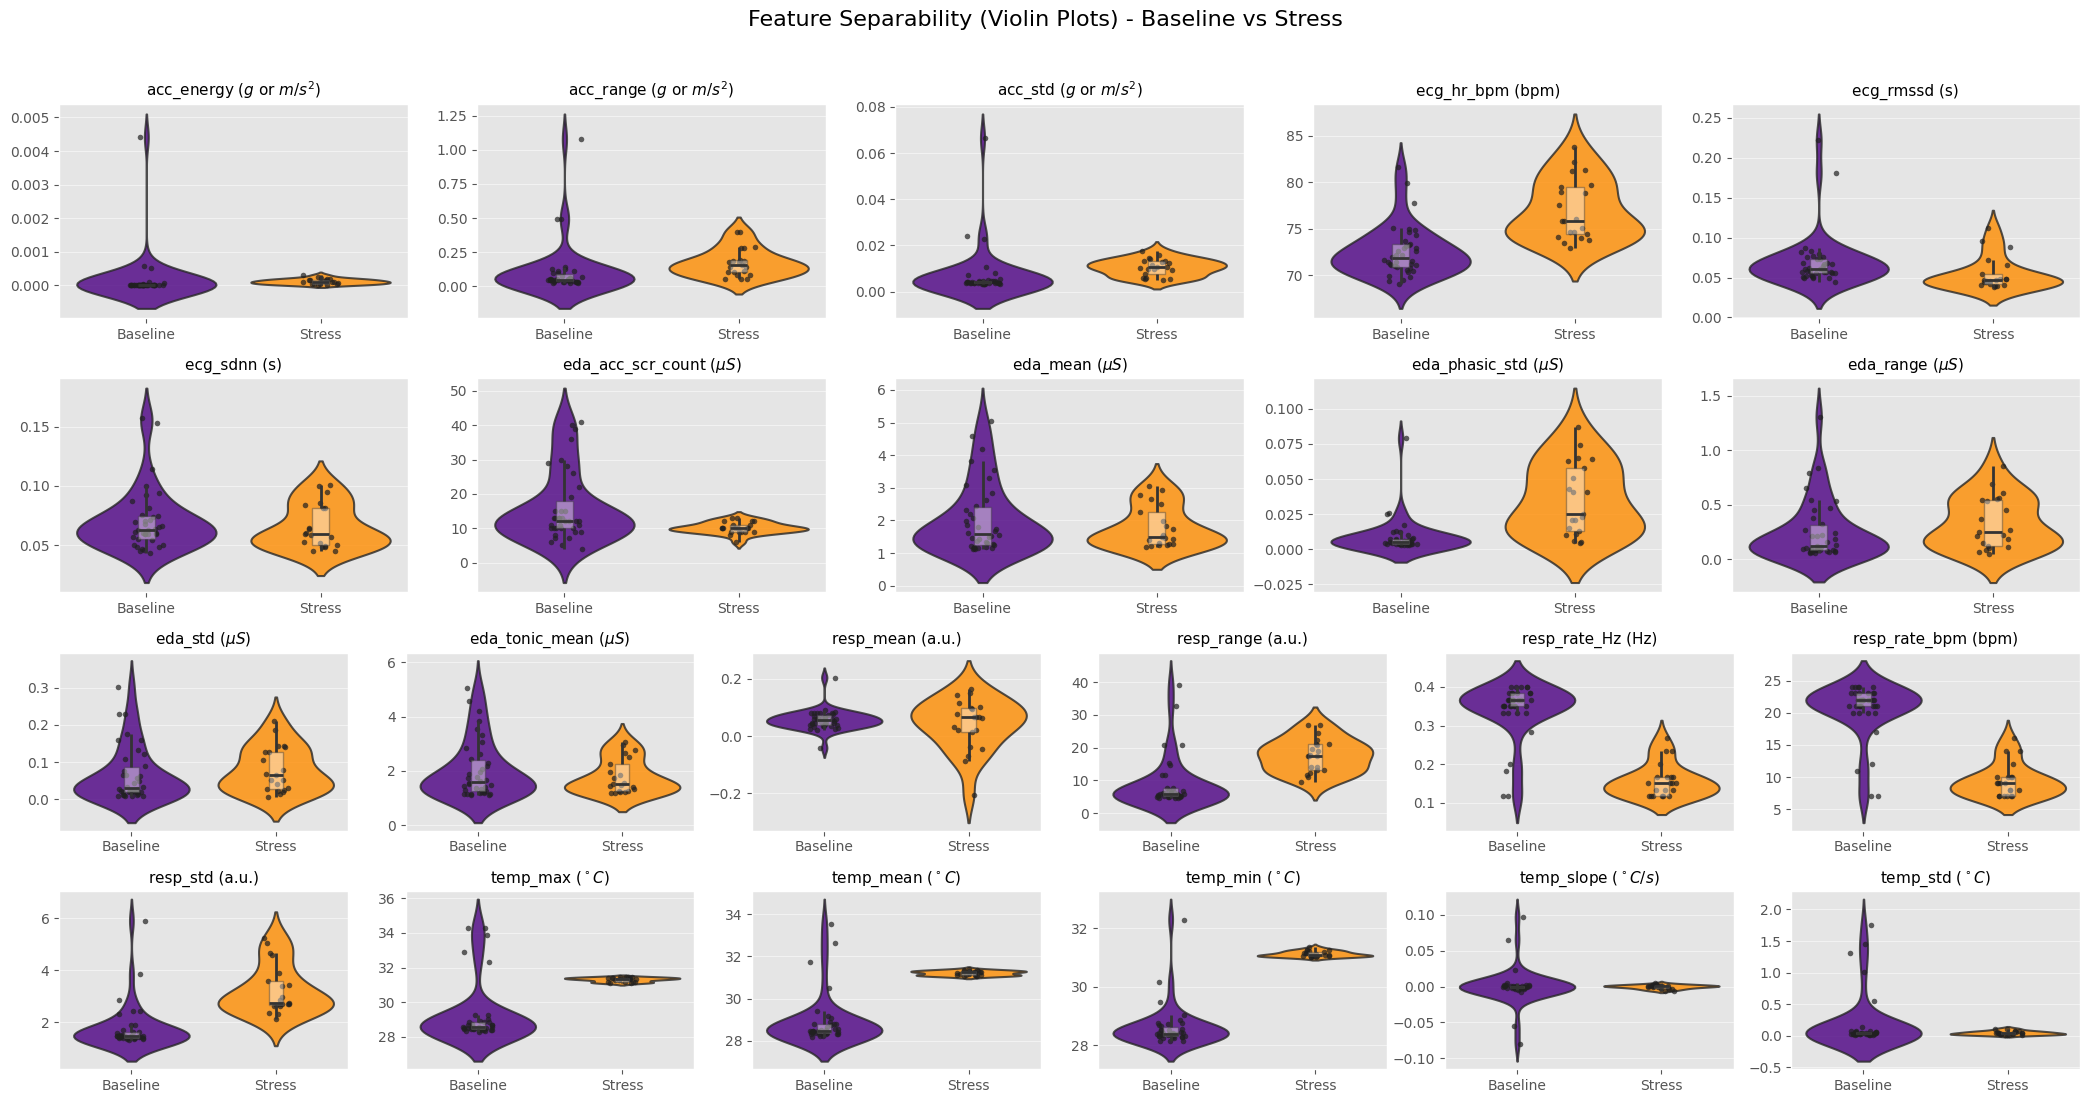

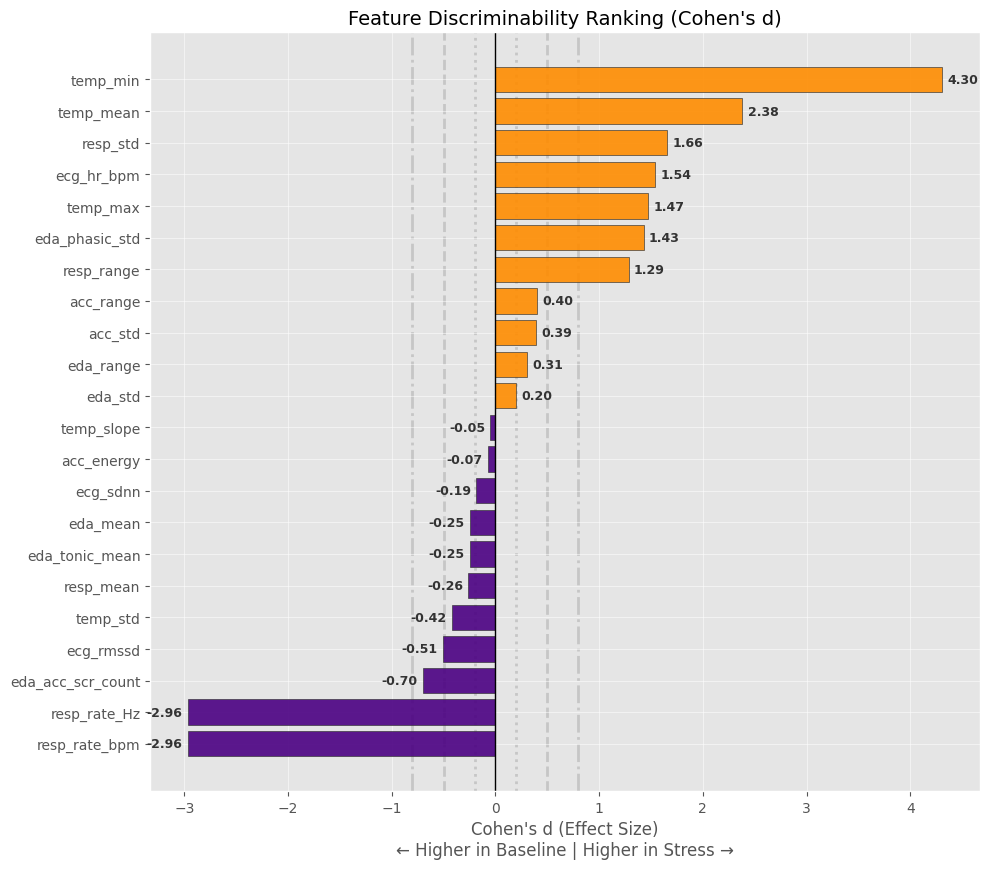

In [7]:
# Limit to first 1000 windows to save time during interactive audit
limit = 1000
audit_windows = windows[:limit]

data = []
for w in audit_windows:
    feats = extractor.extract_features(w)
    feats['label'] = w['label']
    data.append(feats)

df = pd.DataFrame(data)

# Filter for Baseline (1) and Stress (2)
df_filtered = df[df['label'].isin([1, 2])].copy()
df_filtered['label_name'] = df_filtered['label'].map({1: 'Baseline', 2: 'Stress'})

# --- Visualization using Violin Plots ---
# Plot ALL extracted features to be exhaustive
plot_cols = [c for c in df_filtered.columns if c not in ['label', 'label_name']]
plot_cols.sort()

print(f"Plotting {len(plot_cols)} features: {plot_cols}")

loc = config['data'].get('sensor_location', 'chest').upper()

fig_violins = plot_feature_separability(
    df=df_filtered,
    feature_cols=plot_cols,
    label_col='label_name',
    title="Feature Separability (Violin Plots) - Baseline vs Stress",
    save_folder=loc
)
plt.show()

# --- Single Plot of Effect Sizes (Cohen's d) ---
fig_cohen = plot_feature_importance_cohens_d(
    df=df_filtered,
    feature_cols=plot_cols,
    label_col='label_name',
    class_1='Stress',
    class_0='Baseline',
    title="Feature Discriminability Ranking (Cohen's d)",
    save_folder=loc
)
plt.show()

## 8. Feature Correlation & Pair Plot
We visualize the relationships between the "Top 6" most discriminative features (based on Effect Size) to understand redundancy and multivariate separability.
This helps anticipate multicollinearity issues for linear models.

Top diverse discriminative features selected: ['temp_min', 'resp_rate_bpm', 'resp_std', 'ecg_hr_bpm', 'eda_phasic_std', 'eda_acc_scr_count']


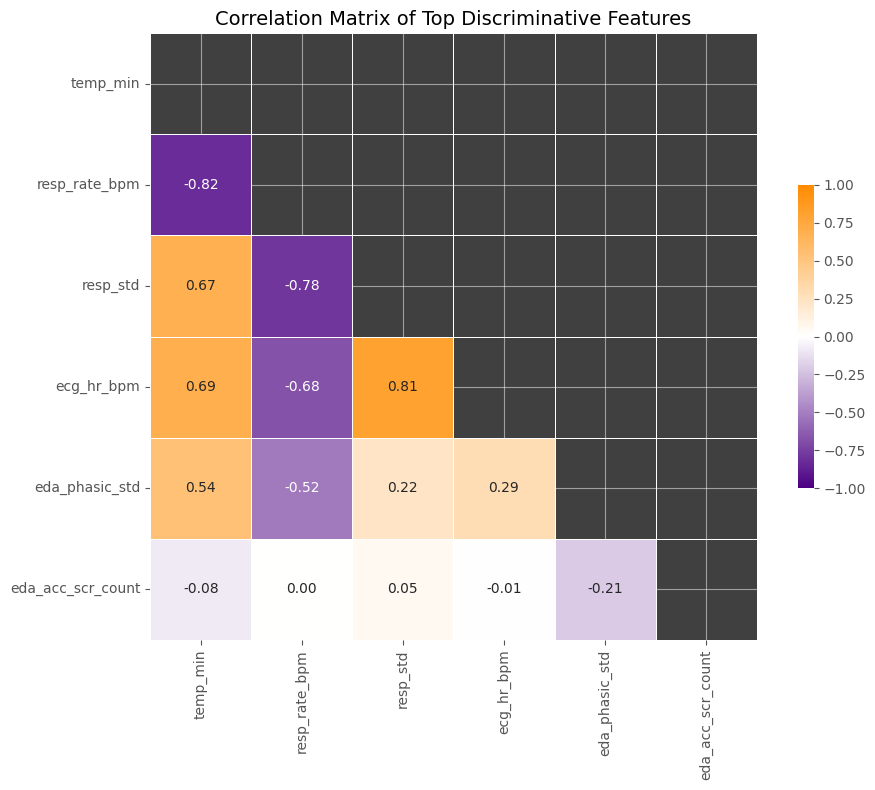

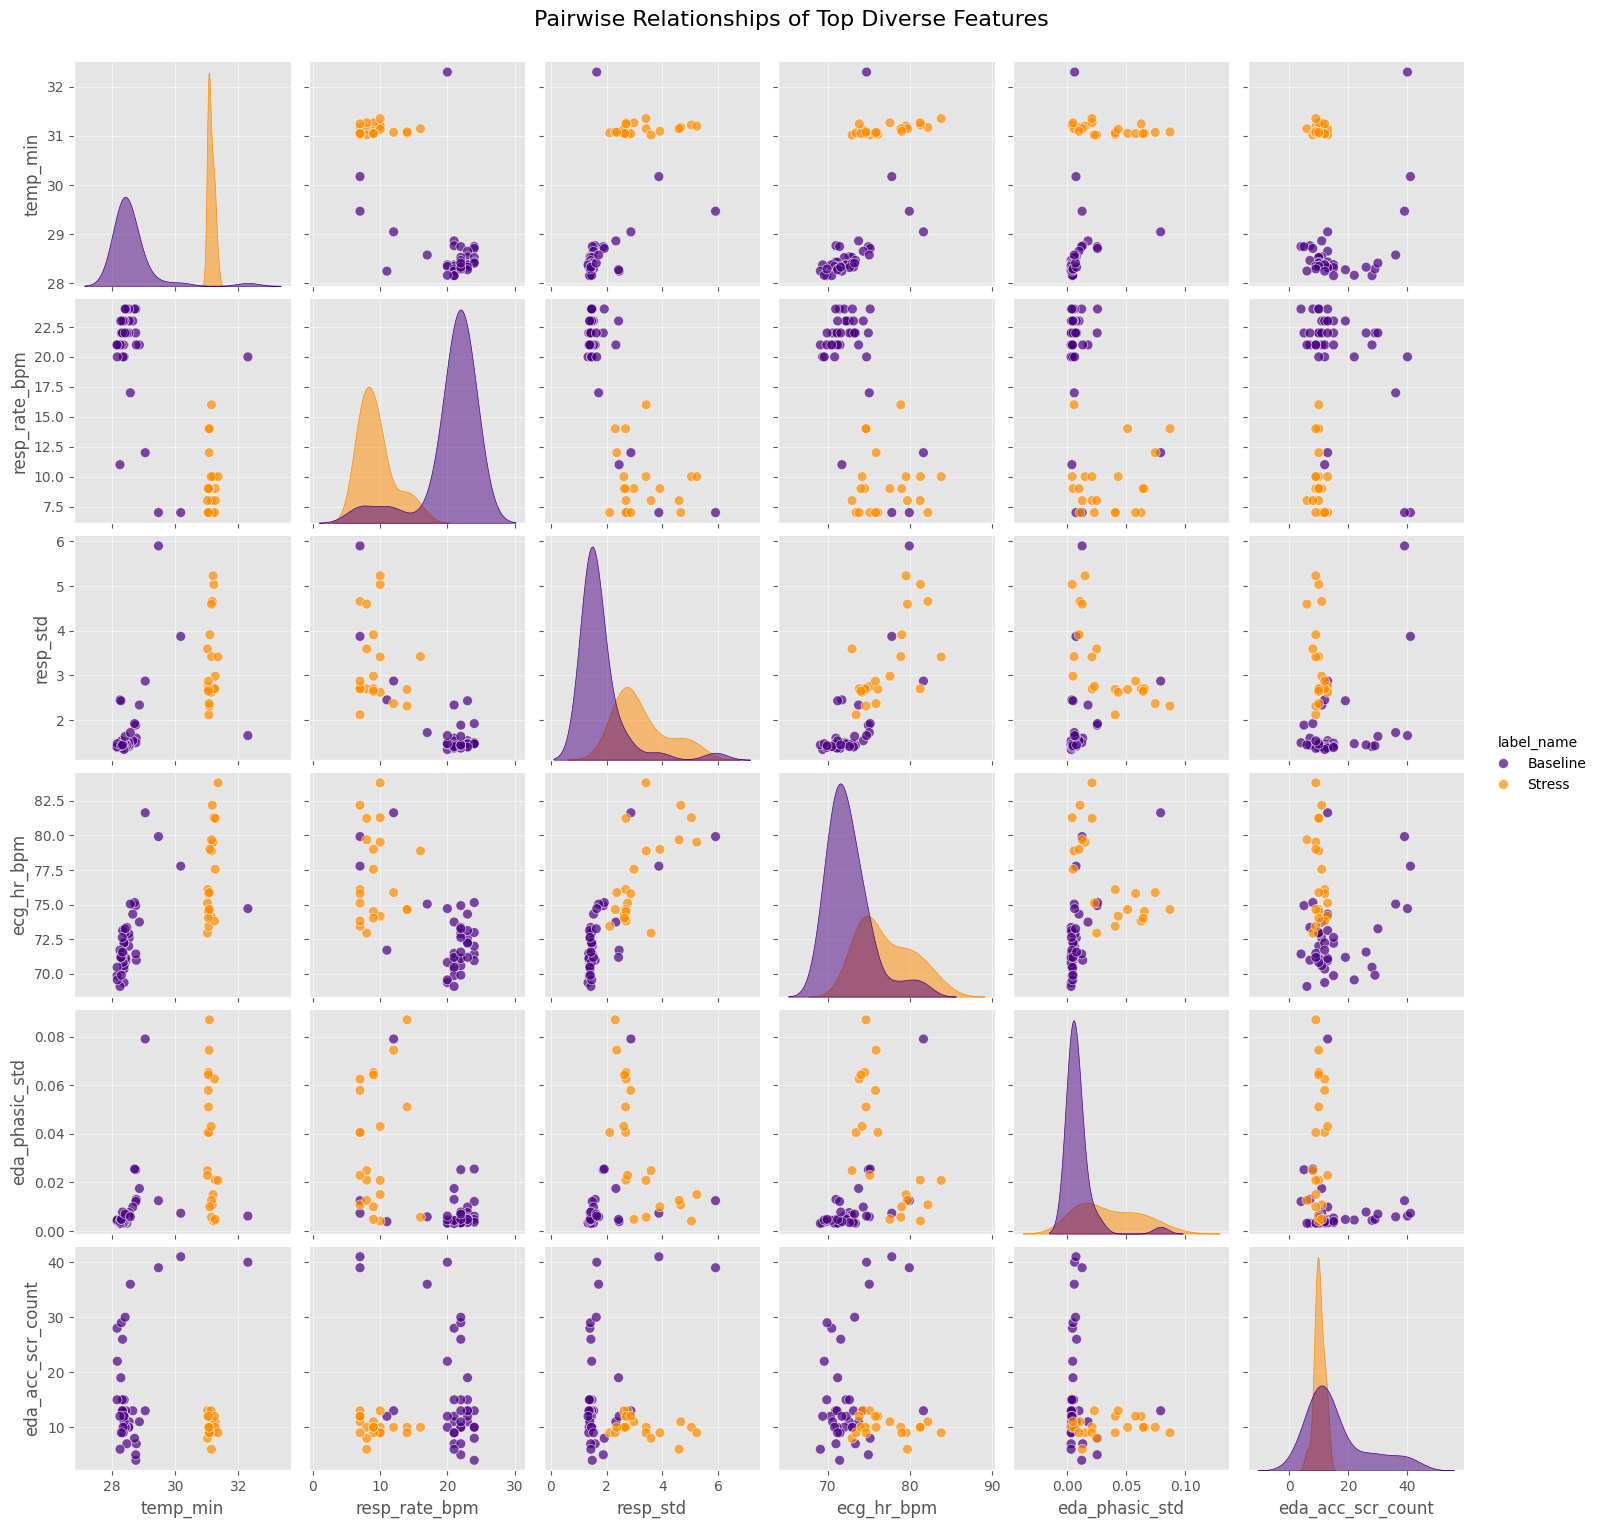

In [8]:
# Retrieve Top Features using the new utility
top_features = get_top_discriminative_features(
    df_filtered, 
    plot_cols, 
    label_col='label_name',
    n=6
)
print(f"Top diverse discriminative features selected: {top_features}")
loc = config['data'].get('sensor_location', 'chest').upper()

# 1. Feature Correlation Matrix
fig_corr = plot_correlation_matrix(
    df=df_filtered,
    feature_cols=top_features,
    title="Correlation Matrix of Top Discriminative Features",
    save_folder=loc
)
plt.show()

# 2. Pair Plot (with larger dots)
g = plot_feature_pairplot(
    df=df_filtered,
    feature_cols=top_features,
    label_col='label_name',
    title="Pairwise Relationships of Top Diverse Features",
    save_folder=loc
)
plt.show()

## 9. Conclusion
The feature extraction logic appears robust visually. The boxplots in Section 7 provide confirmatory evidence that the physiological states are strictly discriminable using our custom feature set.
Next Step: Train Baseline Models (`notebooks/03`).